# Circle Loss MNISTでの実験
- [github](https://github.com/TinyZeaMays/CircleLoss/blob/master/mnist_example.py)のLossを使う
- ネットワークは本当に簡単なものを使用
- 分類モデルはロジスティックとlightgbm
- 評価指標はaccuracy, macro平均のprecision, confusion matrixの可視化

In [28]:
import numpy as np
import matplotlib.pyplot as plt


from typing import Tuple
from tqdm import tqdm
from sklearn import manifold
 
import torch
from torch import nn, Tensor
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import ToTensor
 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
def get_mnist_loader(is_train: bool, batch_size: int) -> DataLoader:
    trainset = datasets.MNIST(
                                root="../data",
                                train=is_train,
                                transform=ToTensor(),
                                download=True
                              )
    return DataLoader(trainset, batch_size=batch_size, shuffle=is_train)
 
# data loder
train_loader = get_mnist_loader(is_train=True, batch_size=64)

In [6]:
def visualize(features, labels, num_classes):
    # t-SNEで2次元に圧縮
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
    features = tsne.fit_transform(features)
    
    # カラーマップ
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    
    plt.figure(figsize=(10, 5))
    # 描画
    for i in range(num_classes):
        plt.plot(features[labels == i, 0], features[labels == i, 1], '.', c=colors[i])

    # グラフ設定
    plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], loc='upper right')
    plt.show()

In [7]:
def convert_label_to_similarity(normed_feature: Tensor, label: Tensor) -> Tuple[Tensor, Tensor]:
    # 行列の掛け算?
    similarity_matrix = normed_feature @ normed_feature.transpose(1, 0)
    # 次元を増やす??
    label_matrix = label.unsqueeze(1) == label.unsqueeze(0)

    positive_matrix = label_matrix.triu(diagonal=1)
    negative_matrix = label_matrix.logical_not().triu(diagonal=1)
    
    # view = reshape
    similarity_matrix = similarity_matrix.view(-1)
    positive_matrix = positive_matrix.view(-1)
    negative_matrix = negative_matrix.view(-1)
    return similarity_matrix[positive_matrix], similarity_matrix[negative_matrix]


class CircleLoss(nn.Module):
    def __init__(self, m: float, gamma: float) -> None:
        super(CircleLoss, self).__init__()
        self.m = m
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp: Tensor, sn: Tensor) -> Tensor:
        ap = torch.clamp_min(- sp.detach() + 1 + self.m, min=0.)
        an = torch.clamp_min(sn.detach() + self.m, min=0.)

        delta_p = 1 - self.m
        delta_n = self.m

        logit_p = - ap * (sp - delta_p) * self.gamma
        logit_n = an * (sn - delta_n) * self.gamma

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))

        return loss

In [8]:
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
 
    def forward(self, input: Tensor) -> Tensor:
        feature = self.feature_extractor(input).mean(dim=[2, 3])
        return nn.functional.normalize(feature)

In [9]:
def train(criterion, epoch):
    print("Training... Epoch = %d" % epoch)
    for img, label in tqdm(train_loader):
        img, label = img.to(device), label.to(device)
        model.zero_grad()
        pred = model(img)
        loss = criterion(*convert_label_to_similarity(pred, label))
        loss.backward()
        optimizer.step()

In [10]:
# model
model = Model().to(device)
 
# optimzer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
sheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.8)
 
# CircleLoss
criterion = CircleLoss(m=0.25, gamma=80).to(device)
 
# Training
for epoch in range(20):
    sheduler.step()
    train(criterion, epoch+1)

/Users/kenta_suzuki/opt/miniconda3/envs/pytorch36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 4/938 [00:00<00:24, 37.62it/s]

Training... Epoch = 1


  1%|          | 6/938 [00:00<00:17, 53.96it/s]

Training... Epoch = 2


  1%|          | 6/938 [00:00<00:17, 53.51it/s]

Training... Epoch = 3


  1%|          | 5/938 [00:00<00:18, 49.35it/s]

Training... Epoch = 4


  1%|          | 6/938 [00:00<00:17, 53.20it/s]

Training... Epoch = 5


  1%|          | 6/938 [00:00<00:16, 55.15it/s]

Training... Epoch = 6


  1%|          | 6/938 [00:00<00:17, 52.93it/s]

Training... Epoch = 7


  1%|          | 5/938 [00:00<00:18, 49.89it/s]

Training... Epoch = 8


  1%|          | 6/938 [00:00<00:17, 53.89it/s]

Training... Epoch = 9


  1%|          | 6/938 [00:00<00:17, 54.75it/s]

Training... Epoch = 10


  1%|          | 6/938 [00:00<00:17, 53.31it/s]

Training... Epoch = 11


  1%|          | 6/938 [00:00<00:17, 52.66it/s]

Training... Epoch = 12


  1%|          | 6/938 [00:00<00:17, 53.28it/s]

Training... Epoch = 13


  1%|          | 6/938 [00:00<00:17, 53.39it/s]

Training... Epoch = 14


  1%|          | 6/938 [00:00<00:17, 54.51it/s]

Training... Epoch = 15


  1%|          | 6/938 [00:00<00:17, 53.47it/s]

Training... Epoch = 16


  1%|          | 6/938 [00:00<00:17, 51.99it/s]

Training... Epoch = 17


  1%|          | 6/938 [00:00<00:17, 52.61it/s]

Training... Epoch = 18


  1%|          | 6/938 [00:00<00:16, 55.92it/s]

Training... Epoch = 19


  1%|          | 6/938 [00:00<00:16, 56.57it/s]

Training... Epoch = 20


100%|██████████| 938/938 [00:16<00:00, 56.32it/s]


In [12]:
# data loader
val_loader = get_mnist_loader(is_train=False, batch_size=2)
 
# 保存用
all_features = []
all_labels = []
 
# 推論
for img, label in tqdm(val_loader):
    img, label = img.to(device), label.to(device)
    pred = model(img)
 
    all_features.append(pred.data.cpu().numpy())
    all_labels.append(label.data.cpu().numpy())
    
# 可視化
all_features = np.concatenate(all_features, 0)
all_labels = np.concatenate(all_labels, 0)

100%|██████████| 5000/5000 [00:03<00:00, 1387.17it/s]


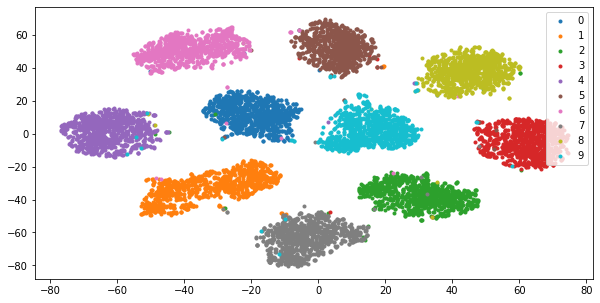

In [13]:
visualize(all_features, all_labels, 10)

分類モデルに投入するためのデータセット作成

In [14]:
def create_classification_dataset(loader):
    features = []
    labels = []
    for img, label in tqdm(loader):
        img, label = img.to(device), label.to(device)
        pred = model(img)
        
        features.append(pred.data.cpu().numpy())
        labels.append(label.data.cpu().numpy())
    features = np.concatenate(features, 0)
    labels = np.concatenate(labels, 0)
    return features, labels

In [16]:
train_loader = get_mnist_loader(is_train=True, batch_size=1)
train_x, train_y = create_classification_dataset(train_loader)

val_loader = get_mnist_loader(is_train=False, batch_size=1)
valid_x, valid_y = create_classification_dataset(val_loader)

100%|██████████| 10000/10000 [00:05<00:00, 1773.95it/s]


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [18]:
clf = LogisticRegression(random_state=0).fit(train_x, train_y)

In [19]:
print("train acc: ", accuracy_score(train_y, clf.predict(train_x)))
print("valid acc: ", accuracy_score(valid_y, clf.predict(valid_x)))

train acc:  0.995
valid acc:  0.9897


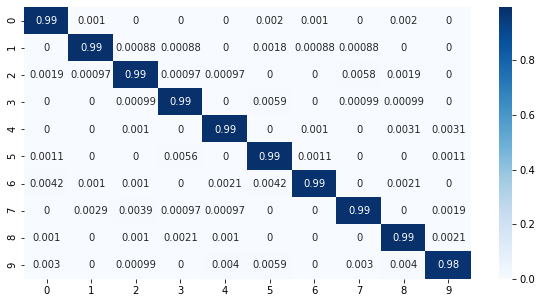

In [26]:
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(valid_y, clf.predict(valid_x), normalize='true'), annot=True, cmap='Blues', fmt='.2g')
plt.show()

In [60]:
train_data = lgb.Dataset(train_x, label=train_y)
eval_data = lgb.Dataset(valid_x, label=valid_y, reference= train_data)

In [61]:
params = {
'task': 'train',
'boosting_type': 'gbdt',
'objective': 'multiclass',
'num_class': np.unique(train_y).shape[0],
'verbose': 2,
}

In [65]:
gbm = lgb.train(
params,
train_data,
valid_sets=eval_data,
num_boost_round=50,
verbose_eval=5,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.630242
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.373858
[LightGBM] [Debug] init for col-wise cost 0.001829 seconds, init for row-wise cost 0.009743 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 32
[LightGBM] [Info] Start training from score -2.315501
[LightGBM] [Info] Start training from score -2.185988
[LightGBM] [Info] Start training from score -2.309610
[LightGBM] [Info] Start training from score -2.280987
[LightGBM] [Info] Start training from score -2.329271
[LightGBM] [Info] Start training from score -2.404064
[LightGBM] [Info] Start training from score -2.316346
[LightGBM] [Info] Start training from score -2.259366
[LightGBM] [Info] S

In [80]:
def create_lgb_pred(model, x):
    preds = model.predict(x)
    pred_y = []

    for x in preds:
        pred_y.append(np.argmax(x))
    return pred_y

In [81]:
pred_y = create_lgb_pred(gbm, valid_x)

In [86]:
print("train acc: ", accuracy_score(train_y, create_lgb_pred(gbm, train_x)))
print("valid acc: ", accuracy_score(valid_y, create_lgb_pred(gbm, valid_x)))

train acc:  1.0
valid acc:  0.9895


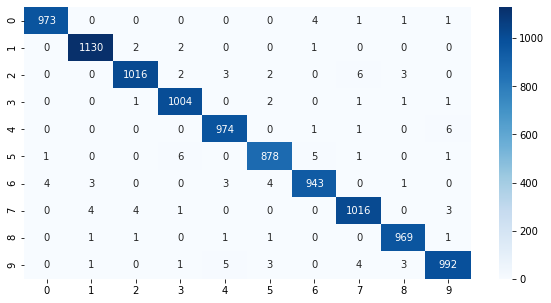

In [79]:
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(valid_y, y_pred), annot=True, cmap='Blues', fmt='g')
plt.show()